# Project Introduction

## Context & Motivation

Financial markets are highly sensitive to news and public sentiment. Recent advances in Natural Language Processing (NLP) allow us to extract sentiment from financial news headlines and explore its impact on market movements. This project investigates whether daily news sentiment can help predict short-term trends in the S&P 500 index.

## Objective

The main objective is to build a machine learning pipeline that uses financial news headlines to generate actionable trading signals for the S&P 500 index. We combine headline sentiment analysis (using FinBERT) with historical price features and train a classification model to forecast market direction.

## Workflow Overview

This project is structured into four main notebooks:
1. **Data Exploration:** Inspect, clean, and understand the news headlines and price dataset.
2. **Sentiment Analysis:** Apply FinBERT to assign sentiment scores to each headline, and engineer additional sentiment-based features.
3. **Feature Engineering & Modeling:** Merge sentiment and price features, define targets (price movement classes), and train/evaluate classification models (e.g., XGBoost).
4. **Evaluation & Insights:** Assess model performance and extract actionable insights, including visualizations and error analysis.

## Limitations & Scope

- The analysis is constrained by the granularity of available news data (daily headlines, not intraday).
- The focus is on practical signal generation, not perfect prediction or backtest optimization.
- Due to time constraints, the modeling approach favors simplicity and transparency.

---

This notebook (1_data_exploration.ipynb) covers the first phase: importing, cleaning, and exploring the dataset to lay the foundation for sentiment analysis and model development.


## 0. Cleaning Data Folder

In [7]:
import os
import glob

# Path to your data folder
data_folder = "../data"

# Delete all CSV files in the data folder
files = glob.glob(os.path.join(data_folder, "*.csv"))
for f in files:
    os.remove(f)

print(f"Cleared {len(files)} file(s) from {data_folder}")

Cleared 1 file(s) from ../data


## 1. Data Import & Setup

We import necessary libraries and load the S&P 500 news headlines dataset, which includes news headlines and daily closing prices for the S&P 500 index from 2008 to 2024.

### Dataset Description

This analysis uses the dataset **“S&P 500 with Financial News Headlines (2008–2024)”** published by Dyuti Dasmahapatra on Kaggle [[1]].

The dataset includes over 19,000 financial news headlines matched with the corresponding **daily closing prices of the S&P 500 index**, covering the period from 2008 to 2024. This allows for joint modeling of market movements and financial news sentiment — a useful setup for market sentiment analysis using models like FinBERT and XGBoost.

#### Columns in the dataset:
- `date`: The date the headline was published.
- `headline`: The financial news headline text.
- `close`: Closing price of the S&P 500 on the corresponding date.

---

### References

[1] Dasmahapatra, D. (2024). *S&P 500 with Financial News Headlines (2008–2024)*. Kaggle. [https://www.kaggle.com/datasets/dyutidasmahaptra/s-and-p-500-with-financial-news-headlines-20082024](https://www.kaggle.com/datasets/dyutidasmahaptra/s-and-p-500-with-financial-news-headlines-20082024)



In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import kagglehub
import os
import shutil

# Set plotting style for consistency
sns.set(style='whitegrid')

# Download dataset
path = kagglehub.dataset_download("dyutidasmahaptra/s-and-p-500-with-financial-news-headlines-20082024")
print("Downloaded dataset to:", path)

# Find the first CSV file in the dataset folder
csv_path = None
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(".csv"):
            csv_path = os.path.join(root, file)
            break
    if csv_path:
        break

if not csv_path:
    raise FileNotFoundError("No CSV file found in dataset.")

# Define relative target path: ../data/sp500_news.csv (from current working dir)
target_dir = os.path.abspath(os.path.join(os.getcwd(), "../data"))
os.makedirs(target_dir, exist_ok=True)
target_path = os.path.join(target_dir, "sp500_news_full.csv")

# Copy the CSV
shutil.copy(csv_path, target_path)

print(f"Dataset saved to: {target_path}")

# Load the dataset
df = pd.read_csv("../data/sp500_news.csv", parse_dates=['Date'])

print("Dataset loaded. Shape:", df.shape)


Downloaded dataset to: C:\Users\louft\.cache\kagglehub\datasets\dyutidasmahaptra\s-and-p-500-with-financial-news-headlines-20082024\versions\1
Dataset saved to: c:\Users\louft\OneDrive\Desktop\MBA\05-HIV25\AI_and_ML\AIML25\FINAL_PROJECT\data\sp500_news_full.csv
Dataset loaded. Shape: (19127, 3)


## 2. Data Overview & Quality Check

A brief preview of the dataset to understand its shape, column names, and example rows. This step is crucial for aligning our expectations with the actual data. We also take the opportunity to check for missing values, duplicates, and any obvious data quality issues (e.g., empty headlines, invalid dates). These insights will help inform our cleaning strategy.

In [9]:
# Show columns and first few rows
print("Columns:", df.columns.tolist())
display(df.head())

# Show data types and non-null counts
display(df.info())

Columns: ['Title', 'Date', 'CP']


,Title,Date,CP
0,"JPMorgan Predicts 2008 Will Be ""Nothing But Net""",2008-01-02,1447.16
1,Dow Tallies Biggest First-session-of-year Poin...,2008-01-02,1447.16
2,2008 predictions for the S&P 500,2008-01-02,1447.16
3,"U.S. Stocks Higher After Economic Data, Monsan...",2008-01-03,1447.16
4,U.S. Stocks Climb As Hopes Increase For More F...,2008-01-07,1416.18


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19127 entries, 0 to 19126
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Title   19127 non-null  object        
 1   Date    19127 non-null  datetime64[ns]
 2   CP      19127 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 448.4+ KB


None

In [10]:
# Check missing values
print(df.isnull().sum())

# Check duplicates
print("Duplicate rows:", df.duplicated(subset=['Title']).sum())

# Quick check for empty headlines
empty_headlines = df['Title'].isnull().sum() + (df['Title'].str.strip() == '').sum()
print("Empty or blank headlines:", empty_headlines)

Title    0
Date     0
CP       0
dtype: int64
Duplicate rows: 1073
Empty or blank headlines: 0


In [11]:
# Remove duplicates based on Title only
before = len(df)
df = df.drop_duplicates(subset=['Title'])
after = len(df)

print(f"Removed {before - after} duplicate titles. {after} unique headlines remain.")

Removed 1073 duplicate titles. 18054 unique headlines remain.


### Data Overview & Quality Assessment

- Initial dataset: 19,127 rows, 3 columns (Title, Date, CP)
- No missing values detected.
- 1,073 duplicate headlines (based on Title) removed; 18,054 unique headlines remain.
- No blank headlines.

The dataset is now clean and ready for analysis.

## 3. Exploratory Data Analysis (EDA)

We conduct initial statistical and visual analysis, including:
- Distribution of closing prices
- Frequency of headlines per day
- Example headlines on key market dates
This step helps us understand both the news and the market context before feature engineering.

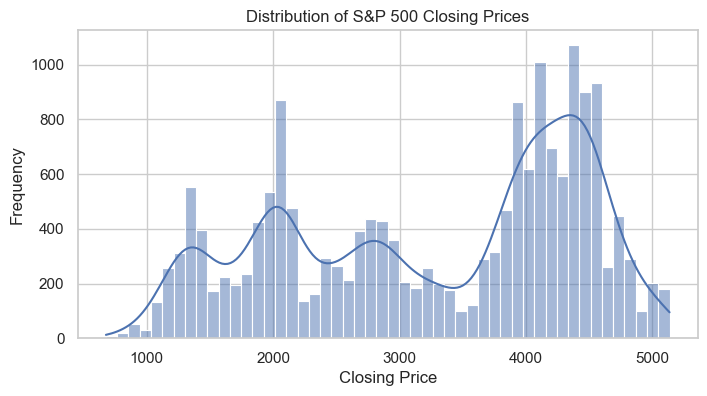

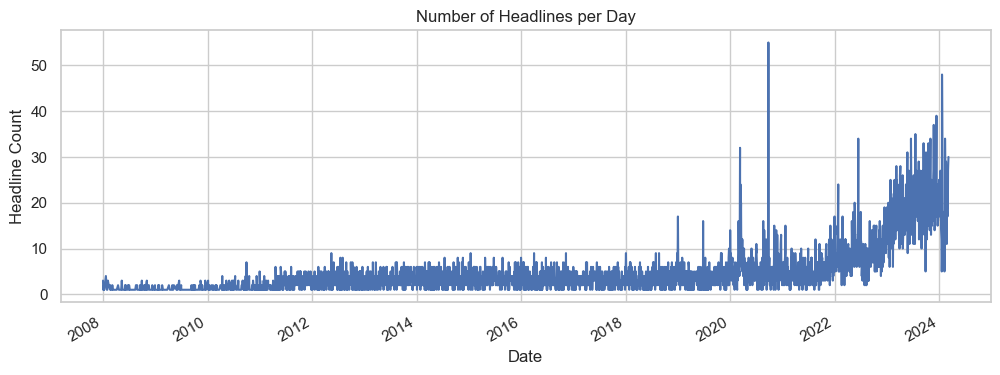

Example headlines on most volatile days:

Date: 2020-03-16 00:00:00


,Title,CP
8728,"S&P 500 Plunged Most Since 1987, Gave Up in 18...",2386.13
8729,Can Mastercard Stock Recover Its Lost Value Po...,2386.13
8730,Is Walmart A Safer Bet During The Current Coro...,2386.13
8731,The U.S. Is In A Bear Market. There Could Be A...,2386.13
8732,Coronavirus stock crash wipes out 80% of Trump...,2386.13
8733,A Discount in SPY? That's Inconceivable!,2386.13
8734,Nasdaq Held Its 200-Week Moving Average - S&P ...,2386.13
8735,Stock markets halted for unprecedented third t...,2386.13
8736,S&P 500: “Limit Down” Index Futures Mask Even ...,2386.13
8737,Dow and US stocks plunge again: Live updates,2386.13



Date: 2009-03-13 00:00:00


,Title,CP
163,Barry Ritholtz's Monkey Theory,756.55



Date: 2009-07-31 00:00:00


,Title,CP
193,July 2009 Crossing Wall Street,987.48


In [12]:
# Distribution of closing prices
plt.figure(figsize=(8, 4))
sns.histplot(df['CP'], bins=50, kde=True)
plt.title("Distribution of S&P 500 Closing Prices")
plt.xlabel("Closing Price")
plt.ylabel("Frequency")
plt.show()

# Headlines per day
headline_counts = df.groupby('Date')['Title'].count()
plt.figure(figsize=(12, 4))
headline_counts.plot()
plt.title("Number of Headlines per Day")
plt.xlabel("Date")
plt.ylabel("Headline Count")
plt.show()

# Example headlines on volatile days (e.g., top 3 biggest daily % moves)
df['CP_shifted'] = df['CP'].shift(1)
df['pct_change'] = df['CP'].pct_change()
top_moves = df.loc[abs(df['pct_change']).sort_values(ascending=False).index[:3]]

print("Example headlines on most volatile days:")
for Date in top_moves['Date'].unique():
    print(f"\nDate: {Date}")
    display(df[df['Date'] == Date][['Title', 'CP']])

## 4. Summary & Takeaways

- **Price Distribution:**  
  The S&P 500 closing prices display several distinct peaks and troughs, highlighting key phases of market growth and volatility over time.

- **Headline Coverage:**  
  The volume of daily news headlines rises sharply after 2020, meaning the dataset is much richer and denser in recent years. Early periods (pre-2015) are relatively sparse in headline data.

- **Volatility & Headlines:**  
  The most volatile trading days (e.g., the 2020 COVID-19 crash) are associated with a high frequency of news headlines and heightened market sentiment—often reflecting panic or uncertainty.

- **Data Quality:**  
  After removing 1,073 duplicate headlines, the dataset contains 18,054 unique headlines, with no missing values in key columns.

**Takeaways:**  
- Model performance will likely be strongest on recent years due to denser headline data.
- Market crises are well-captured in both price and news data, supporting sentiment–price relationship analysis.
- Analysis on early years should be interpreted with caution due to sparse headline coverage.

**Conclusion:**
  To ensure the model is trained on market conditions and news flow that best reflect the current and foreseeable environment, we focus our analysis on the period from January 2020 to June 2024. This window includes unprecedented volatility, major shifts in global sentiment, and aligns with the densest portion of the available headline data.

In [14]:
# Filter on dates to focus our analysis on the period from January 2020 to June 2024
df = df[df['Date'] >= '2020-01-01']

# Export truncated dataframe for use in subsequent modeling notebooks.
df.to_csv('../data/sp500_news.csv', index=False)